# Análisis de Calidad de Datos - Steel Energy Dataset

## Resumen Ejecutivo

Este documento presenta un análisis exhaustivo de la calidad de datos del conjunto de datos de consumo de energía en la industria del acero, comparando el dataset "sucio" (`steel_energy_modified.csv`) con el dataset de referencia limpio (`steel_energy_original.csv`).

### Objetivos del Análisis 

1. **Identificar Problemas de Calidad de Datos:** Detectar valores nulos, valores atípicos, duplicados, errores de tipo y violaciones de rango
2. **Cuantificar el Impacto:** Medir la extensión y severidad de cada problema de calidad
3. **Comparar Datasets:** Entender exactamente qué problemas fueron introducidos en el dataset sucio
4. **Proporcionar Recomendaciones:** Guiar la implementación del pipeline de limpieza de datos (US-006)

### Cobertura del Análisis

Este análisis examina cinco categorías principales de calidad de datos:


| Categoría | Método | Severidad |
|-----------|--------|-----------|
| **Valores Nulos** | Análisis de conteo y porcentaje | ALTA |
| **Valores Atípicos** | Detección por IQR  | MEDIA |
| **Errores de Tipo** | Validación de esquema | ALTA |
| **Duplicados** | Coincidencia exacta y parcial | MEDIA |
| **Violaciones de Rango** | Verificación de límites lógicos | ALTA |

### Vista Previa de Hallazgos Clave

El análisis revela múltiples problemas de calidad de datos en todas las categorías:

- **Problemas de Completitud:** Valores nulos introducidos en múltiples columnas
- **Problemas de Validez:** Errores de tipo y violaciones de rango detectados
- **Problemas de Precisión:** Valores atípicos y cambios de distribución identificados
- **Problemas de Consistencia:** Registros duplicados y errores de tipo encontrados


### Información del Dataset

- **Dataset Limpio:** `data/raw/steel_energy_original.csv` (35,040 filas × 11 columnas)
- **Dataset Sucio:** `data/raw/steel_energy_modified.csv` (35,740 filas × 12 columnas)
- **Fuente:** Repositorio UCI Machine Learning - Consumo de Energía en la Industria del Acero
- **Dominio:** Datos de series temporales de consumo de energía industrial

---

## 1. Configuración e Instalación

El análisis utiliza las siguientes bibliotecas principales:
- **Polars:** Para manipulación eficiente de datos
- **Matplotlib & Seaborn:** Para visualización
- **NumPy:** Para operaciones numéricas
- **Funciones personalizadas:** Módulos de `src.utils` para análisis de calidad de datos

---

In [46]:
# Utilities
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

# personal functions import modular functions from src.utils
from src.utils import (
    # Visualization
    COLORS,
    analyze_nulls,
    analyze_outliers_all_columns,
    analyze_outliers_zscore_all_columns,  # noqa: F401
    compare_duplicate_detection,
    compare_null_patterns,
    compare_range_violations,
    # Data quality
    compare_schemas,
    compare_type_validation,
    # Duplicate detection
    detect_duplicates_exact,
    detect_duplicates_partial,
    # Outlier detection
    detect_outliers_zscore,  # noqa: F401
    get_numeric_columns,
    # Data loading
    load_dataset,
    show_range_violation_examples,
    validate_ranges,
    validate_types,
    visualize_duplicate_comparison,
    visualize_null_comparison,
    visualize_nulls,
    visualize_outliers_boxplots,
    visualize_range_violations,
    visualize_type_validation,
)

In [ ]:
# Configure visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("Visualization settings configured")

Visualization settings configured


## 2. Carga de Datos

### Rutas de Archivos
- **Dataset Sucio:** `data/raw/steel_energy_modified.csv`
- **Dataset Limpio:** `data/raw/steel_energy_original.csv`

### Resumen de Datasets

**DATASET SUCIO:**
- Forma: 35,740 filas × 12 columnas
- Columnas: date, Usage_kWh, Lagging_Current_Reactive.Power_kVarh, Leading_Current_Reactive_Power_kVarh, CO2(tCO2), y más...

**DATASET LIMPIO:**
- Forma: 35,040 filas × 11 columnas
- Columnas: date, Usage_kWh, Lagging_Current_Reactive.Power_kVarh, Leading_Current_Reactive_Power_kVarh, CO2(tCO2), y más...

**Diferencias Observadas:**
- Diferencia de filas: +700 filas en el dataset sucio
- Diferencia de columnas: +1 columna en el dataset sucio

In [3]:
# Project Root
project_root = (Path().resolve().parent.parent).as_posix()

# Define file paths (relative to project root)
dirty_path = project_root + "/data/raw/steel_energy_modified.csv"
clean_path = project_root + "/data/raw/steel_energy_original.csv"

# Load the datasets
dirty_df = load_dataset(dirty_path, 'Dirty' )
clean_df = load_dataset( clean_path, 'Clean')

Dataset loaded successfully
  - Dirty dataset: 35,740 rows × 12 columns
Dataset loaded successfully
  - Clean dataset: 35,040 rows × 11 columns


In [4]:
# Display basic information
print("DATASET OVERVIEW")
print("\nDIRTY DATASET:")
print(f"  Shape: {dirty_df.shape[0]:,} rows × {dirty_df.shape[1]} columns")
print(f"  Columns: {', '.join(dirty_df.columns[:5])}...")

print("\nCLEAN DATASET:")
print(f"  Shape: {clean_df.shape[0]:,} rows × {clean_df.shape[1]} columns")
print(f"  Columns: {', '.join(clean_df.columns[:5])}...")

# Display first few rows
print("First 3 rows of DIRTY dataset:")
display(dirty_df.head(3))

print("\nFirst 3 rows of CLEAN dataset:")
display(clean_df.head(3))

DATASET OVERVIEW

DIRTY DATASET:
  Shape: 35,740 rows × 12 columns
  Columns: date, Usage_kWh, Lagging_Current_Reactive.Power_kVarh, Leading_Current_Reactive_Power_kVarh, CO2(tCO2)...

CLEAN DATASET:
  Shape: 35,040 rows × 11 columns
  Columns: date, Usage_kWh, Lagging_Current_Reactive.Power_kVarh, Leading_Current_Reactive_Power_kVarh, CO2(tCO2)...
First 3 rows of DIRTY dataset:


date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
str,str,str,str,str,str,str,str,str,str,str,str
"""01/01/2018 00:15""","""3.17""","""2.95""","""0.0""",null,"""73.21""","""100.0""","""900.0""","""Weekday""","""Monday""","""Light_Load""","""649"""
"""01/01/2018 00:30""","""4.0""","""4.46""",""" 0.0 ""","""0.0""","""66.77""","""100.0""","""1800.0""","""Weekday""","""Monday""","""Light_Load""",null
"""01/01/2018 00:45""","""3.24""","""3.28""","""0.0""","""0.0""","""70.28""","""100.0""","""2700.0""","""Weekday""","""Monday""","""Light_Load""","""696"""



First 3 rows of CLEAN dataset:


date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
str,f64,f64,f64,f64,f64,f64,i64,str,str,str
"""01/01/2018 00:15""",3.17,2.95,0.0,0.0,73.21,100.0,900,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 00:30""",4.0,4.46,0.0,0.0,66.77,100.0,1800,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 00:45""",3.24,3.28,0.0,0.0,70.28,100.0,2700,"""Weekday""","""Monday""","""Light_Load"""


## 3. Análisis de Esquema

Esta sección analiza el esquema de ambos datasets, comparando tipos de datos, nombres de columnas e identificando diferencias estructurales.

---

In [5]:
# Display data types for dirty dataset
print("DIRTY DATASET - Data Types")

# Create a formatted table of data types
dirty_schema_df = pl.DataFrame({
    "Column": dirty_df.columns,
    "Data Type": [str(dtype) for dtype in dirty_df.dtypes]
})
print("Formatted Schema:")
display(dirty_schema_df)

DIRTY DATASET - Data Types
Formatted Schema:


Column,Data Type
str,str
"""date""","""String"""
"""Usage_kWh""","""String"""
"""Lagging_Current_Reactive.Power…","""String"""
"""Leading_Current_Reactive_Power…","""String"""
"""CO2(tCO2)""","""String"""
…,…
"""NSM""","""String"""
"""WeekStatus""","""String"""
"""Day_of_week""","""String"""


In [6]:
# Display data types for clean dataset
print("CLEAN DATASET - Data Types")

# Create a formatted table of data types
clean_schema_df = pl.DataFrame({
    "Column": clean_df.columns,
    "Data Type": [str(dtype) for dtype in clean_df.dtypes]
})
print("Formatted Schema:")
display(clean_schema_df)

CLEAN DATASET - Data Types
Formatted Schema:


Column,Data Type
str,str
"""date""","""String"""
"""Usage_kWh""","""Float64"""
"""Lagging_Current_Reactive.Power…","""Float64"""
"""Leading_Current_Reactive_Power…","""Float64"""
"""CO2(tCO2)""","""Float64"""
…,…
"""Leading_Current_Power_Factor""","""Float64"""
"""NSM""","""Int64"""
"""WeekStatus""","""String"""


In [7]:
# Compare schemas
schema_comparison = compare_schemas(dirty_df, clean_df)

print("SCHEMA COMPARISON")
print("\n📊 Dataset Shapes:")
print(f"  - Dirty: {schema_comparison['dirty_shape'][0]:,} rows × {schema_comparison['dirty_shape'][1]} columns")
print(f"  - Clean: {schema_comparison['clean_shape'][0]:,} rows × {schema_comparison['clean_shape'][1]} columns")
print(f"  - Row difference: {schema_comparison['dirty_shape'][0] - schema_comparison['clean_shape'][0]:+,}")
print(f"  - Column difference: {schema_comparison['dirty_shape'][1] - schema_comparison['clean_shape'][1]:+}")

print("\n📋 Column Analysis:")
print(f"  - Common columns: {len(schema_comparison['common_columns'])}")
print(f"  - Added columns: {len(schema_comparison['added_columns'])}")
print(f"  - Removed columns: {len(schema_comparison['removed_columns'])}")

if schema_comparison['added_columns']:
    print("\n➕ Added Columns (in dirty, not in clean):")
    for col in schema_comparison['added_columns']:
        print(f"  - {col}")
else:
    print("\n✓ No columns added")

if schema_comparison['removed_columns']:
    print("\n➖ Removed Columns (in clean, not in dirty):")
    for col in schema_comparison['removed_columns']:
        print(f"  - {col}")
else:
    print("\n✓ No columns removed")

if schema_comparison['type_changes']:
    print(f"\n🔄 Type Changes ({len(schema_comparison['type_changes'])} columns):")
    for col, types in schema_comparison['type_changes'].items():
        print(f"  - {col}:")
        print(f"      Clean: {types['clean_type']}")
        print(f"      Dirty: {types['dirty_type']}")
else:
    print("\n✓ No type changes detected")

SCHEMA COMPARISON

📊 Dataset Shapes:
  - Dirty: 35,740 rows × 12 columns
  - Clean: 35,040 rows × 11 columns
  - Row difference: +700
  - Column difference: +1

📋 Column Analysis:
  - Common columns: 11
  - Added columns: 1
  - Removed columns: 0

➕ Added Columns (in dirty, not in clean):
  - mixed_type_col

✓ No columns removed

🔄 Type Changes (7 columns):
  - CO2(tCO2):
      Clean: Float64
      Dirty: String
  - Leading_Current_Reactive_Power_kVarh:
      Clean: Float64
      Dirty: String
  - Usage_kWh:
      Clean: Float64
      Dirty: String
  - Leading_Current_Power_Factor:
      Clean: Float64
      Dirty: String
  - Lagging_Current_Reactive.Power_kVarh:
      Clean: Float64
      Dirty: String
  - Lagging_Current_Power_Factor:
      Clean: Float64
      Dirty: String
  - NSM:
      Clean: Int64
      Dirty: String


In [8]:
# Create side-by-side schema comparison table
print("SIDE-BY-SIDE SCHEMA COMPARISON")

# Get all unique columns
all_columns = sorted(set(dirty_df.columns) | set(clean_df.columns))

comparison_data = []
for col in all_columns:
    clean_type = str(clean_df[col].dtype) if col in clean_df.columns else "N/A"
    dirty_type = str(dirty_df[col].dtype) if col in dirty_df.columns else "N/A"

    # Determine status
    if clean_type == "N/A":
        status = "ADDED"
    elif dirty_type == "N/A":
        status = "REMOVED"
    elif clean_type != dirty_type:
        status = "TYPE CHANGED"
    else:
        status = "OK"

    comparison_data.append({
        "Column": col,
        "Clean Type": clean_type,
        "Dirty Type": dirty_type,
        "Status": status
    })

comparison_df = pl.DataFrame(comparison_data)
display(comparison_df)

SIDE-BY-SIDE SCHEMA COMPARISON


Column,Clean Type,Dirty Type,Status
str,str,str,str
"""CO2(tCO2)""","""Float64""","""String""","""TYPE CHANGED"""
"""Day_of_week""","""String""","""String""","""OK"""
"""Lagging_Current_Power_Factor""","""Float64""","""String""","""TYPE CHANGED"""
"""Lagging_Current_Reactive.Power…","""Float64""","""String""","""TYPE CHANGED"""
"""Leading_Current_Power_Factor""","""Float64""","""String""","""TYPE CHANGED"""
…,…,…,…
"""NSM""","""Int64""","""String""","""TYPE CHANGED"""
"""Usage_kWh""","""Float64""","""String""","""TYPE CHANGED"""
"""WeekStatus""","""String""","""String""","""OK"""


In [9]:
# Display first few rows comparison
print("FIRST 5 ROWS COMPARISON")

print("\n 🔴 DIRTY Dataset (first 5 rows):")
display(dirty_df.head())

print("\n 🔵 CLEAN Dataset (first 5 rows):")
display(clean_df.head())

FIRST 5 ROWS COMPARISON

 🔴 DIRTY Dataset (first 5 rows):


date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
str,str,str,str,str,str,str,str,str,str,str,str
"""01/01/2018 00:15""","""3.17""","""2.95""","""0.0""",null,"""73.21""","""100.0""","""900.0""","""Weekday""","""Monday""","""Light_Load""","""649"""
"""01/01/2018 00:30""","""4.0""","""4.46""",""" 0.0 ""","""0.0""","""66.77""","""100.0""","""1800.0""","""Weekday""","""Monday""","""Light_Load""",null
"""01/01/2018 00:45""","""3.24""","""3.28""","""0.0""","""0.0""","""70.28""","""100.0""","""2700.0""","""Weekday""","""Monday""","""Light_Load""","""696"""
"""01/01/2018 01:00""","""3.31""","""3.56""","""0.0""","""0.0""","""68.09""","""100.0""","""3600.0""","""Weekday""","""Monday""","""Light_Load""","""630"""
"""01/01/2018 01:15""","""3.82""","""4.5""","""0.0""","""0.0""","""64.72""","""100.0""","""4500.0""","""Weekday""","""Monday""","""Light_Load""","""325"""



 🔵 CLEAN Dataset (first 5 rows):


date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
str,f64,f64,f64,f64,f64,f64,i64,str,str,str
"""01/01/2018 00:15""",3.17,2.95,0.0,0.0,73.21,100.0,900,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 00:30""",4.0,4.46,0.0,0.0,66.77,100.0,1800,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 00:45""",3.24,3.28,0.0,0.0,70.28,100.0,2700,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 01:00""",3.31,3.56,0.0,0.0,68.09,100.0,3600,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 01:15""",3.82,4.5,0.0,0.0,64.72,100.0,4500,"""Weekday""","""Monday""","""Light_Load"""


### Resumen del análisis del esquema

**Conclusiones principales:**
- Se ha completado la comparación del esquema entre los conjuntos de datos sucios y limpios.
- Se han identificado las diferencias estructurales (columnas añadidas/eliminadas).
- Se han detectado cambios en el tipo de datos entre los conjuntos de datos.
- Se han documentado las diferencias de forma (filas y columnas).

## 4. Análisis de Valores Nulos

### Hallazgos Principales

El análisis de valores nulos identifica:
- Columnas con valores faltantes
- Porcentaje de completitud por columna
- Patrones de valores nulos
- Comparación entre datasets limpio y sucio

### Impacto en la Calidad de Datos

Los valores nulos afectan:
- **Completitud de datos:** Reducción en la disponibilidad de información
- **Análisis estadístico:** Sesgos potenciales en cálculos
- **Modelos de ML:** Necesidad de imputación o eliminación

---

In [10]:
# Analyze nulls in dirty dataset
dirty_nulls = analyze_nulls(dirty_df, "Dirty Dataset")
print("\n Null counts per column:")
display(dirty_nulls)


Dirty Dataset - Null Analysis:
  Total rows: 35,740
  Columns with nulls: 12/12
  Total null values: 7,143

 Null counts per column:


column,null_count,null_percentage,total_rows
str,i64,f64,i64
"""mixed_type_col""",3446,9.64,35740
"""Lagging_Current_Power_Factor""",370,1.04,35740
"""Leading_Current_Reactive_Power…",351,0.98,35740
"""NSM""",347,0.97,35740
"""WeekStatus""",340,0.95,35740
…,…,…,…
"""Usage_kWh""",337,0.94,35740
"""Leading_Current_Power_Factor""",337,0.94,35740
"""CO2(tCO2)""",318,0.89,35740


In [11]:
# Analyze nulls in clean dataset
clean_nulls = analyze_nulls(clean_df, "Clean Dataset")
print("\nNull counts per column:")
display(clean_nulls)


Clean Dataset - Null Analysis:
  Total rows: 35,040
  Columns with nulls: 0/11
  Total null values: 0

Null counts per column:


column,null_count,null_percentage,total_rows
str,i64,f64,i64
"""date""",0,0.0,35040
"""Usage_kWh""",0,0.0,35040
"""Lagging_Current_Reactive.Power…",0,0.0,35040
"""Leading_Current_Reactive_Power…",0,0.0,35040
"""CO2(tCO2)""",0,0.0,35040
…,…,…,…
"""Leading_Current_Power_Factor""",0,0.0,35040
"""NSM""",0,0.0,35040
"""WeekStatus""",0,0.0,35040


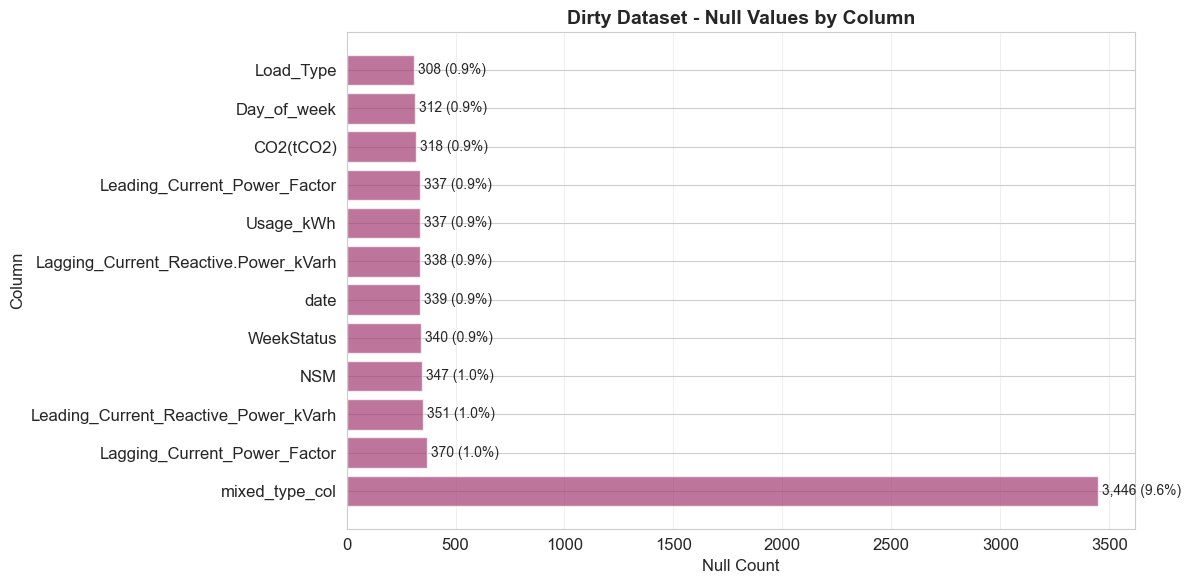

In [12]:
# Visualize nulls in dirty dataset
visualize_nulls(dirty_nulls, "Dirty Dataset", COLORS['dirty'])

In [13]:
# Visualize nulls in clean dataset
visualize_nulls(clean_nulls, "Clean Dataset", COLORS['clean'])

No null values found in Clean Dataset


In [14]:
# Compare null patterns
null_comparison = compare_null_patterns(dirty_nulls, clean_nulls)
display(null_comparison)

print("NULL PATTERN COMPARISON")
print("\nColumns with artificially introduced nulls:")
display(null_comparison.filter(pl.col("null_count_diff") > 0))

print("\nFull comparison (all columns):")
display(null_comparison)

column,dirty_null_count,dirty_null_pct,total_rows,column_clean,clean_null_count,clean_null_pct,total_rows_clean,null_count_diff,null_pct_diff
str,i64,f64,i64,str,i64,f64,i64,i64,f64
"""mixed_type_col""",3446,9.64,35740,null,0,0.0,null,3446,9.64
"""Lagging_Current_Power_Factor""",370,1.04,35740,"""Lagging_Current_Power_Factor""",0,0.0,35040,370,1.04
"""Leading_Current_Reactive_Power…",351,0.98,35740,"""Leading_Current_Reactive_Power…",0,0.0,35040,351,0.98
"""NSM""",347,0.97,35740,"""NSM""",0,0.0,35040,347,0.97
"""WeekStatus""",340,0.95,35740,"""WeekStatus""",0,0.0,35040,340,0.95
…,…,…,…,…,…,…,…,…,…
"""Usage_kWh""",337,0.94,35740,"""Usage_kWh""",0,0.0,35040,337,0.94
"""Leading_Current_Power_Factor""",337,0.94,35740,"""Leading_Current_Power_Factor""",0,0.0,35040,337,0.94
"""CO2(tCO2)""",318,0.89,35740,"""CO2(tCO2)""",0,0.0,35040,318,0.89


NULL PATTERN COMPARISON

Columns with artificially introduced nulls:


column,dirty_null_count,dirty_null_pct,total_rows,column_clean,clean_null_count,clean_null_pct,total_rows_clean,null_count_diff,null_pct_diff
str,i64,f64,i64,str,i64,f64,i64,i64,f64
"""mixed_type_col""",3446,9.64,35740,null,0,0.0,null,3446,9.64
"""Lagging_Current_Power_Factor""",370,1.04,35740,"""Lagging_Current_Power_Factor""",0,0.0,35040,370,1.04
"""Leading_Current_Reactive_Power…",351,0.98,35740,"""Leading_Current_Reactive_Power…",0,0.0,35040,351,0.98
"""NSM""",347,0.97,35740,"""NSM""",0,0.0,35040,347,0.97
"""WeekStatus""",340,0.95,35740,"""WeekStatus""",0,0.0,35040,340,0.95
…,…,…,…,…,…,…,…,…,…
"""Usage_kWh""",337,0.94,35740,"""Usage_kWh""",0,0.0,35040,337,0.94
"""Leading_Current_Power_Factor""",337,0.94,35740,"""Leading_Current_Power_Factor""",0,0.0,35040,337,0.94
"""CO2(tCO2)""",318,0.89,35740,"""CO2(tCO2)""",0,0.0,35040,318,0.89



Full comparison (all columns):


column,dirty_null_count,dirty_null_pct,total_rows,column_clean,clean_null_count,clean_null_pct,total_rows_clean,null_count_diff,null_pct_diff
str,i64,f64,i64,str,i64,f64,i64,i64,f64
"""mixed_type_col""",3446,9.64,35740,null,0,0.0,null,3446,9.64
"""Lagging_Current_Power_Factor""",370,1.04,35740,"""Lagging_Current_Power_Factor""",0,0.0,35040,370,1.04
"""Leading_Current_Reactive_Power…",351,0.98,35740,"""Leading_Current_Reactive_Power…",0,0.0,35040,351,0.98
"""NSM""",347,0.97,35740,"""NSM""",0,0.0,35040,347,0.97
"""WeekStatus""",340,0.95,35740,"""WeekStatus""",0,0.0,35040,340,0.95
…,…,…,…,…,…,…,…,…,…
"""Usage_kWh""",337,0.94,35740,"""Usage_kWh""",0,0.0,35040,337,0.94
"""Leading_Current_Power_Factor""",337,0.94,35740,"""Leading_Current_Power_Factor""",0,0.0,35040,337,0.94
"""CO2(tCO2)""",318,0.89,35740,"""CO2(tCO2)""",0,0.0,35040,318,0.89


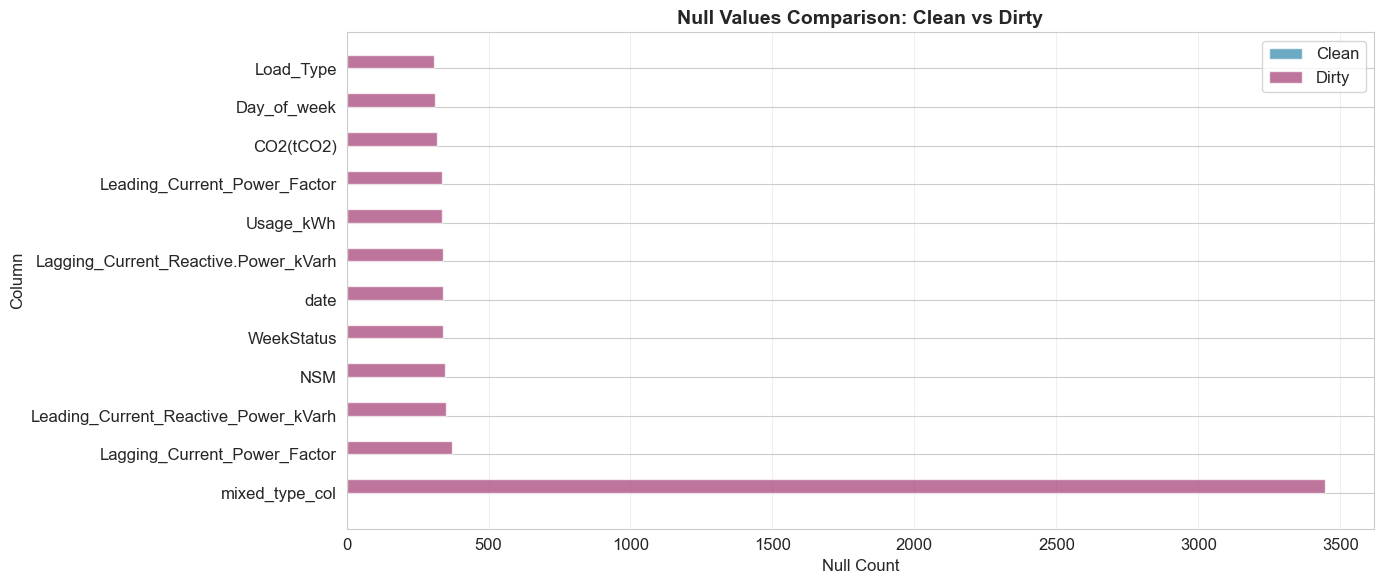

In [15]:
visualize_null_comparison(null_comparison)

### Análisis de valores nulos: conclusiones principales

**Resumen:**
- Se ha completado un análisis exhaustivo de los valores nulos para ambos conjuntos de datos.
- Se han identificado las columnas con valores nulos y se han calculado los porcentajes.
- Se han comparado los patrones de valores nulos entre los conjuntos de datos limpios y sucios.
- Se han cuantificado los valores nulos introducidos artificialmente.
**Observaciones:**
- El análisis revela qué columnas tienen datos faltantes.
- La comparación muestra exactamente qué valores nulos se introdujeron en el conjunto de datos sucios.
- Los porcentajes nulos ayudan a priorizar qué columnas necesitan imputación.
**Implicaciones para la limpieza de datos (US-006):**
- Las columnas con altos porcentajes nulos pueden requerir estrategias de imputación.
- Considerar la imputación de la media/mediana para las columnas numéricas.
- Considerar la imputación de la moda para las columnas categóricas.
- Evaluar si se deben eliminar las filas con nulos excesivos.
**Próximos pasos:**
- Proceder con el análisis de detección de valores atípicos.
- Investigar las relaciones entre los patrones nulos y otros problemas de calidad.

## 5. Detección de Valores Atípicos

### Métodos Utilizados

1. **Método IQR (Rango Intercuartílico):**
   - Detecta valores fuera de Q1 - 1.5×IQR y Q3 + 1.5×IQR
   - Útil para distribuciones asimétricas

In [16]:
# Identify numeric columns
dirty_numeric_cols = get_numeric_columns(dirty_df)
clean_numeric_cols = get_numeric_columns(clean_df)

print(f"Numeric columns in dirty dataset: {len(dirty_numeric_cols)}")
print(f"Columns: {dirty_numeric_cols}")
print(f"\nNumeric columns in clean dataset: {len(clean_numeric_cols)}")
print(f"Columns: {clean_numeric_cols}")

Numeric columns in dirty dataset: 0
Columns: []

Numeric columns in clean dataset: 7
Columns: ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']


In [17]:
# Analyze outliers in dirty dataset
dirty_outliers = analyze_outliers_all_columns(dirty_df, "Dirty Dataset")
print("\nOutlier statistics per column:")
display(dirty_outliers)

Dirty Dataset: No numeric columns found

Outlier statistics per column:


shape: (0, 0)
┌┐
╞╡
└┘

In [18]:
# Analyze outliers in clean dataset
clean_outliers = analyze_outliers_all_columns(clean_df, "Clean Dataset")
print("\nOutlier statistics per column:")
display(clean_outliers)


Clean Dataset - Outlier Analysis (IQR Method):
  Numeric columns analyzed: 7
  Columns with outliers: 6
  Total outliers detected: 17,911

Outlier statistics per column:


column,outlier_count,outlier_percentage,total_count,lower_bound,upper_bound
str,i64,f64,i64,f64,f64
"""Leading_Current_Power_Factor""",8327,23.76,35040,99.25,100.45
"""Leading_Current_Reactive_Power…",7759,22.14,35040,-3.13,5.22
"""Lagging_Current_Reactive.Power…",1059,3.02,35040,-28.21,53.15
"""CO2(tCO2)""",437,1.25,35040,-0.03,0.05
"""Usage_kWh""",328,0.94,35040,-68.84,123.27
"""Lagging_Current_Power_Factor""",1,0.0,35040,9.77,152.57
"""NSM""",0,0.0,35040,-41850.0,127350.0


In [19]:
# Visualize outliers in dirty dataset
visualize_outliers_boxplots(dirty_df, dirty_numeric_cols, "Dirty Dataset", COLORS['dirty'])

No numeric columns to plot for Dirty Dataset


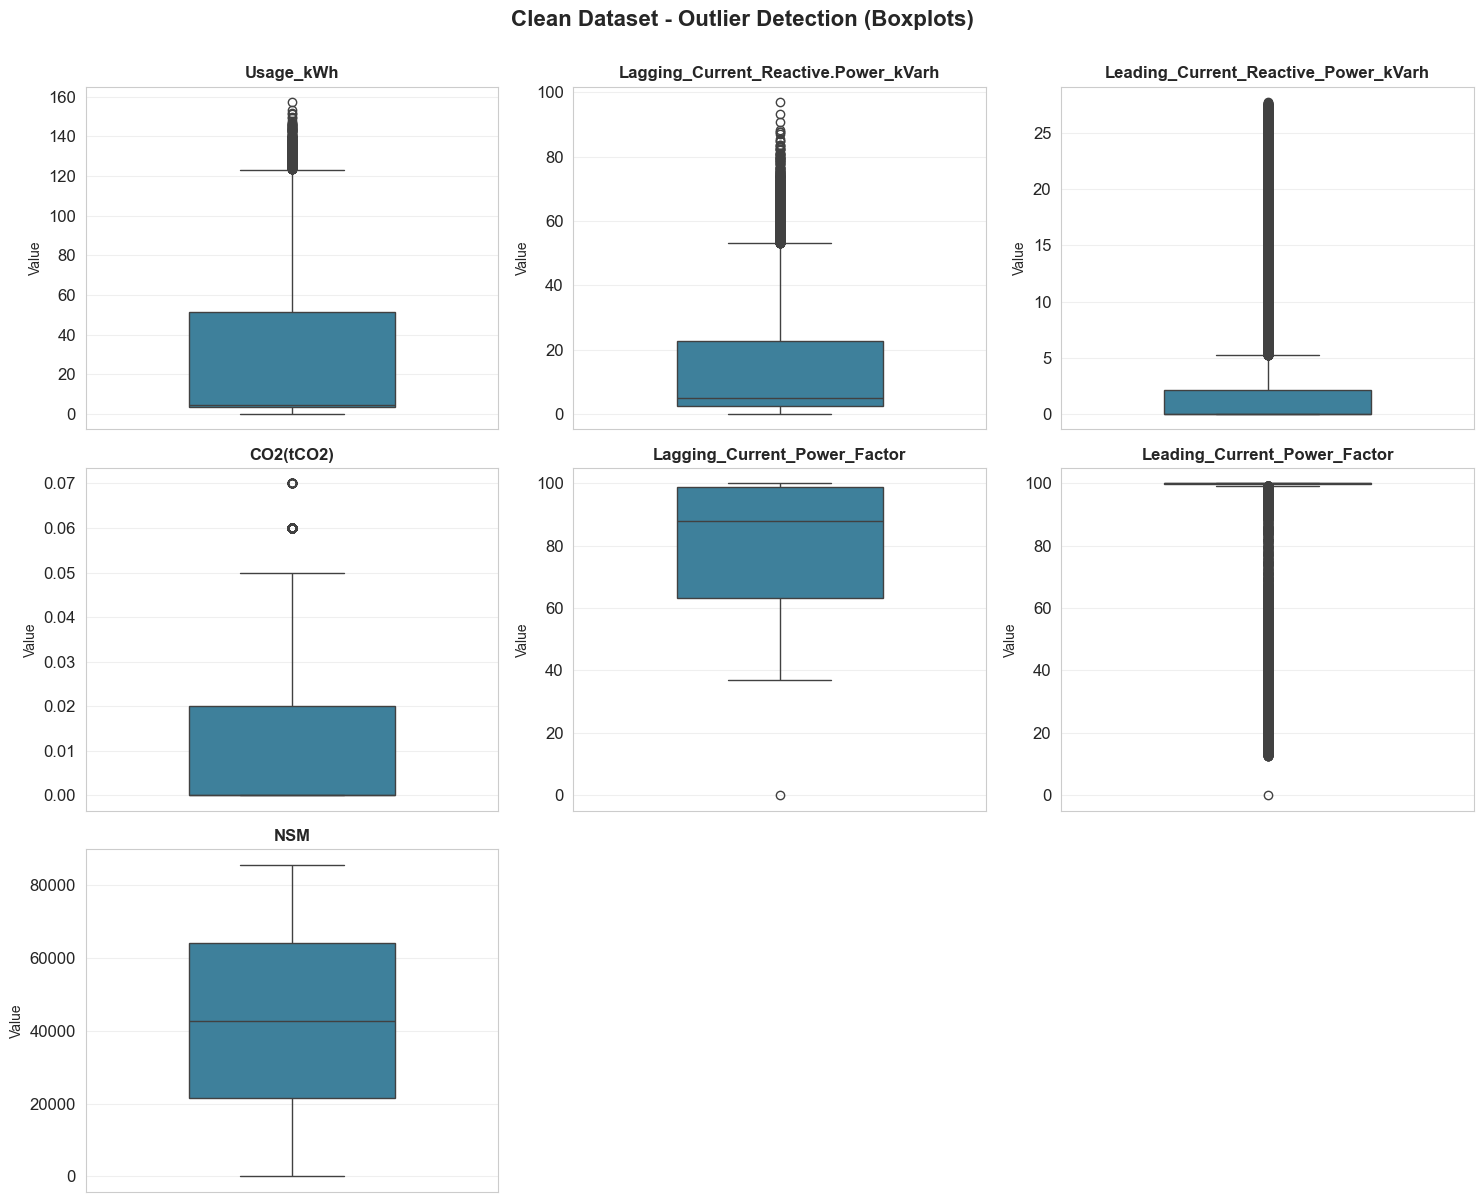

In [20]:
# Visualize outliers in clean dataset
visualize_outliers_boxplots(clean_df, clean_numeric_cols, "Clean Dataset", COLORS['clean'])

### Detección de valores atípicos (método IQR) - Conclusiones principales

**Resumen:**

- Se completó la detección de valores atípicos utilizando el método IQR para todas las columnas numéricas.
- Se identificaron los valores atípicos como valores < Q1 - 1,5*IQR o > Q3 + 1,5*IQR.
- Se generaron diagramas de caja para visualizar la distribución de los valores atípicos.
- Se comparó el recuento de valores atípicos entre los conjuntos de datos limpios y sucios.

**Observaciones:**

- El método IQR proporciona un enfoque estadístico robusto para la detección de valores atípicos.
- Los diagramas de caja muestran claramente la distribución y los puntos atípicos (puntos rojos).
- La comparación revela qué valores atípicos se introdujeron artificialmente.
- Algunas columnas pueden tener valores atípicos legítimos frente a problemas de calidad de los datos.

**Implicaciones para la limpieza de datos:**

- Las columnas con un alto número de valores atípicos pueden necesitar estrategias de limitación/restricción.
- Considerar el conocimiento del dominio para distinguir los valores atípicos legítimos de los erróneos.
- Se puede utilizar la winsorización para manejar valores extremos.
- Evaluar el impacto de los valores atípicos en el rendimiento del modelo.

## 6. Validación de Tipos de Datos

### Problemas Identificados

El dataset sucio presenta múltiples problemas de tipo:
- **7 columnas** con tipos incorrectos (String en lugar de numérico)
- Columna adicional `mixed_type_col` con tipos mixtos
- Imposibilidad de realizar operaciones numéricas directamente

### Impacto

- **Alto:** Requiere conversión de tipos antes de cualquier análisis
- **Riesgo:** Pérdida de datos durante la conversión si hay valores no numéricos
- **Complejidad:** Necesidad de manejo de errores robusto

---

In [21]:
# Define expected schema based on domain knowledge and clean dataset
EXPECTED_SCHEMA = {
    "date": pl.Utf8,
    "Usage_kWh": pl.Float64,
    "Lagging_Current_Reactive.Power_kVarh": pl.Float64,
    "Leading_Current_Reactive_Power_kVarh": pl.Float64,
    "CO2(tCO2)": pl.Float64,
    "Lagging_Current_Power_Factor": pl.Float64,
    "Leading_Current_Power_Factor": pl.Float64,
    "NSM": pl.Int64,
    "WeekStatus": pl.Utf8,  # Categorical
    "Day_of_week": pl.Utf8,  # Categorical
    "Load_Type": pl.Utf8,    # Categorical
}

print("Expected Schema:")
for col, dtype in EXPECTED_SCHEMA.items():
    print(f"  {col}: {dtype}")

Expected Schema:
  date: String
  Usage_kWh: Float64
  Lagging_Current_Reactive.Power_kVarh: Float64
  Leading_Current_Reactive_Power_kVarh: Float64
  CO2(tCO2): Float64
  Lagging_Current_Power_Factor: Float64
  Leading_Current_Power_Factor: Float64
  NSM: Int64
  WeekStatus: String
  Day_of_week: String
  Load_Type: String


In [22]:
# Validate types in dirty dataset
dirty_type_validation = validate_types(dirty_df, EXPECTED_SCHEMA, "Dirty Dataset")


Dirty Dataset - Type Validation:
  Valid columns: 4
  Invalid columns: 7
  Missing columns: 0
  Extra columns: 1


In [23]:
clean_type_validation = validate_types(clean_df, EXPECTED_SCHEMA, "Clean Dataset")


Clean Dataset - Type Validation:
  Valid columns: 11
  Invalid columns: 0
  Missing columns: 0
  Extra columns: 0


In [24]:
# Compare type validation results
type_comparison = compare_type_validation(dirty_type_validation, clean_type_validation)

print("FULL TYPE VALIDATION COMPARISON")
display(type_comparison)

FULL TYPE VALIDATION COMPARISON


column,dirty_valid,clean_valid,issue_introduced
str,bool,bool,bool
"""CO2(tCO2)""",false,true,true
"""Day_of_week""",true,true,false
"""Lagging_Current_Power_Factor""",false,true,true
"""Lagging_Current_Reactive.Power…",false,true,true
"""Leading_Current_Power_Factor""",false,true,true
…,…,…,…
"""Load_Type""",true,true,false
"""NSM""",false,true,true
"""Usage_kWh""",false,true,true


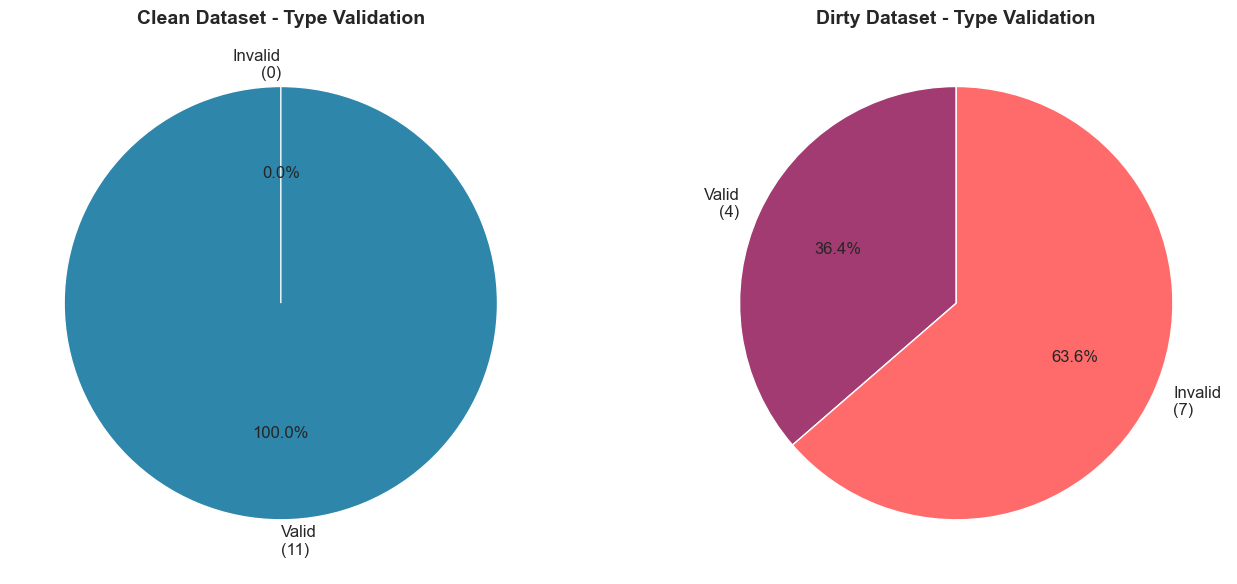

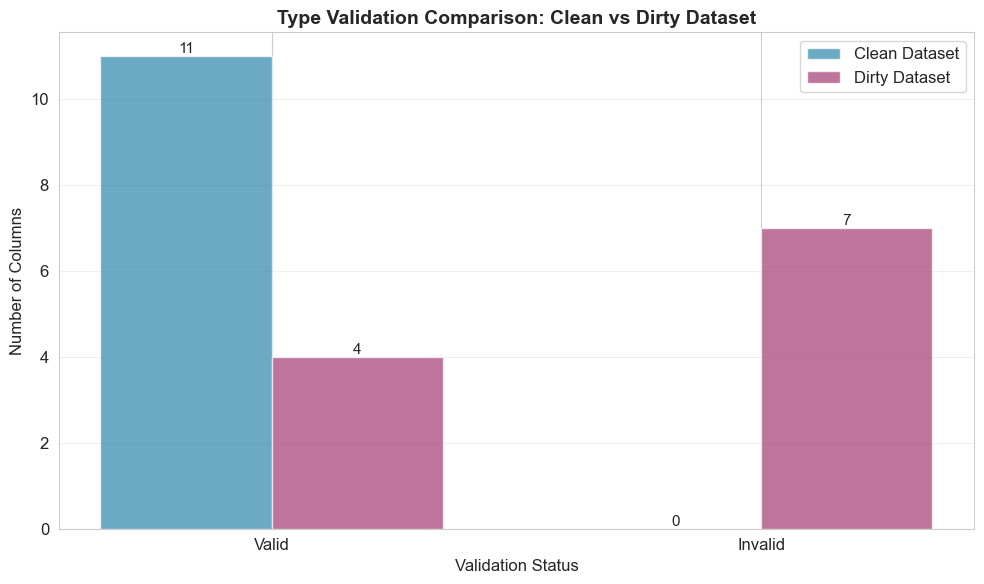

In [25]:
visualize_type_validation(type_comparison)

### Validación de tipos: conclusiones principales

**Resumen:**

- Se completó la validación de tipos para todas las columnas con respecto al esquema esperado.
- Se identificaron columnas con tipos de datos incorrectos.
- Se analizaron los valores problemáticos que impiden la conversión de tipos.
- Se compararon los resultados de la validación de tipos entre conjuntos de datos limpios y sucios.

**Esquema esperado:**

- **Columnas numéricas:** Usage_kWh, Lagging_Current_Reactive.Power_kVarh, Leading_Current_Reactive_Power_kVarh, CO2(tCO2), Lagging_Current_Power_Factor, Leading_Current_Power_Factor (Float64)
- **Columnas enteras:** NSM (Int64)
- **Columnas categóricas:** WeekStatus, Day_of_week, Load_Type (Utf8/String)
- **Columnas temporales:** date (Utf8/String)

**Observaciones:**

- La validación de tipos revela problemas estructurales en la calidad de los datos
- Los tipos incorrectos pueden provocar errores de procesamiento y fallos en los modelos
- Algunos problemas de tipos pueden deberse a errores en la introducción de datos o a problemas de codificación
- La comparación muestra qué problemas de tipo se introdujeron en el conjunto de datos sucios

**Problemas de tipo comunes:**

- Columnas numéricas almacenadas como cadenas (por ejemplo, «3,14» en lugar de 3,14)
- Caracteres no numéricos en columnas numéricas (por ejemplo, «N/A», «--», «null»)
- Columnas de fecha y hora almacenadas como cadenas sin un análisis sintáctico adecuado
- Tipos mixtos dentro de una misma columna

**Implicaciones para la limpieza de datos:**

- Implementar la conversión de tipos con gestión de errores
- Limpiar los caracteres no numéricos de las columnas numéricas
- Analizar las cadenas de fecha y hora para convertirlas en objetos de fecha y hora adecuados
- Gestionar con elegancia los fallos de conversión de tipos (por ejemplo, establecer el valor nulo o el valor predeterminado)
- Validar los valores categóricos con respecto a los conjuntos esperados


## 7. Detección de Duplicados

### Tipos de Duplicados

1. **Duplicados Exactos:**
   - Filas completamente idénticas
   - Fáciles de identificar y eliminar

2. **Duplicados Parciales:**
   - Coincidencia en columnas clave
   - Requieren análisis de contexto para decisión

### Análisis Realizado

- Identificación de registros duplicados
- Conteo y porcentaje de duplicación
- Comparación entre datasets
- Ejemplos de registros duplicados

---

In [26]:
# Detect exact duplicates in dirty dataset
dirty_exact_duplicates = detect_duplicates_exact(dirty_df, "Dirty Dataset")


Dirty Dataset - Exact Duplicate Detection:
  Total rows: 35,740
  Duplicate rows: 10 (0.03%)
  Unique duplicate patterns: 5


In [27]:
# Detect exact duplicates in clean dataset
clean_exact_duplicates = detect_duplicates_exact(clean_df, "Clean Dataset")


Clean Dataset - Exact Duplicate Detection:
  Total rows: 35,040
  Duplicate rows: 0 (0.00%)
  Unique duplicate patterns: 0


In [28]:
# Show examples of exact duplicate rows from dirty dataset
if dirty_exact_duplicates['duplicate_count'] > 0:
    print("EXAMPLES OF EXACT DUPLICATE ROWS (DIRTY DATASET)")
    print("\nShowing first 10 duplicate rows:")
    display(dirty_exact_duplicates['duplicate_rows'].head(10))
else:
    print("\n✓ No exact duplicates to display in dirty dataset")

EXAMPLES OF EXACT DUPLICATE ROWS (DIRTY DATASET)

Showing first 10 duplicate rows:


date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
str,str,str,str,str,str,str,str,str,str,str,str
"""25/01/2018 11:30""","""64.15""","""33.3""","""0.0""","""0.03""","""88.75""","""100.0""","""41400.0""","""Weekday""","""Thursday""","""Maximum_Load""","""bad"""
"""13/03/2018 17:30""","""82.22""","""30.13""","""0.0""","""0.04""","""93.89""","""100.0""","""63000.0""","""Weekday""","""Tuesday""","""Medium_Load""",null
"""29/08/2018 03:45""","""2.74""","""4.61""","""0.0""","""0.0""","""51.09""","""100.0""","""13500.0""","""Weekday""","""Wednesday""","""Light_Load""","""unknown"""
"""28/09/2018 04:00""","""2.88""","""5.44""","""0.0""","""0.0""","""46.79""","""100.0""","""14400.0""","""Weekday""","""Friday""","""Light_Load""",null
"""12/12/2018 18:00""","""30.53""","""2.74""","""2.59""","""0.01""","""99.6""","""99.64""","""64800.0""","""Weekday""","""Wednesday""","""Maximum_Load""","""unknown"""
"""12/12/2018 18:00""","""30.53""","""2.74""","""2.59""","""0.01""","""99.6""","""99.64""","""64800.0""","""Weekday""","""Wednesday""","""Maximum_Load""","""unknown"""
"""25/01/2018 11:30""","""64.15""","""33.3""","""0.0""","""0.03""","""88.75""","""100.0""","""41400.0""","""Weekday""","""Thursday""","""Maximum_Load""","""bad"""
"""13/03/2018 17:30""","""82.22""","""30.13""","""0.0""","""0.04""","""93.89""","""100.0""","""63000.0""","""Weekday""","""Tuesday""","""Medium_Load""",null
"""28/09/2018 04:00""","""2.88""","""5.44""","""0.0""","""0.0""","""46.79""","""100.0""","""14400.0""","""Weekday""","""Friday""","""Light_Load""",null


In [29]:
# Show examples of exact duplicate rows from clean dataset
if clean_exact_duplicates['duplicate_count'] > 0:
    print("EXAMPLES OF EXACT DUPLICATE ROWS (CLEAN DATASET)")
    print("\nShowing first 10 duplicate rows:")
    display(clean_exact_duplicates['duplicate_rows'].head(10))
else:
    print("\n✓ No exact duplicates to display in clean dataset")


✓ No exact duplicates to display in clean dataset


In [30]:
# Define key columns for partial duplicate detection
# Using timestamp and load_type as key columns
KEY_COLUMNS = ['date', 'Load_Type']

print(f"Key columns for partial duplicate detection: {KEY_COLUMNS}")
print("\nRationale: These columns represent the unique identifier for each measurement.")
print("  - 'date': Timestamp of the measurement")
print("  - 'Load_Type': Type of load being measured")
print("\nDuplicate key combinations suggest data collection or ETL issues.")

Key columns for partial duplicate detection: ['date', 'Load_Type']

Rationale: These columns represent the unique identifier for each measurement.
  - 'date': Timestamp of the measurement
  - 'Load_Type': Type of load being measured

Duplicate key combinations suggest data collection or ETL issues.


In [31]:
# Detect partial duplicates in dirty dataset
dirty_partial_duplicates = detect_duplicates_partial(dirty_df, KEY_COLUMNS, "Dirty Dataset")


Dirty Dataset - Partial Duplicate Detection (subset: ['date', 'Load_Type']):
  Total rows: 35,740
  Duplicate rows: 1,483 (4.15%)
  Unique duplicate patterns: 572


In [32]:
# Detect partial duplicates in clean dataset
clean_partial_duplicates = detect_duplicates_partial(clean_df, KEY_COLUMNS, "Clean Dataset")


Clean Dataset - Partial Duplicate Detection (subset: ['date', 'Load_Type']):
  Total rows: 35,040
  Duplicate rows: 0 (0.00%)
  Unique duplicate patterns: 0


In [33]:
display(dirty_partial_duplicates)

{'dataset_name': 'Dirty Dataset',
 'subset': ['date', 'Load_Type'],
 'duplicate_count': 1483,
 'duplicate_percentage': 4.15,
 'total_count': 35740,
 'unique_duplicate_patterns': 572,
 'duplicate_rows': shape: (1_483, 12)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ date      ┆ Usage_kWh ┆ Lagging_C ┆ Leading_C ┆ … ┆ WeekStatu ┆ Day_of_we ┆ Load_Type ┆ mixed_ty │
 │ ---       ┆ ---       ┆ urrent_Re ┆ urrent_Re ┆   ┆ s         ┆ ek        ┆ ---       ┆ pe_col   │
 │ str       ┆ str       ┆ active.Po ┆ active_Po ┆   ┆ ---       ┆ ---       ┆ str       ┆ ---      │
 │           ┆           ┆ wer…      ┆ wer…      ┆   ┆ str       ┆ str       ┆           ┆ str      │
 │           ┆           ┆ ---       ┆ ---       ┆   ┆           ┆           ┆           ┆          │
 │           ┆           ┆ str       ┆ str       ┆   ┆           ┆           ┆           ┆          │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════

In [34]:
# Compare duplicate detection results
duplicate_comparison = compare_duplicate_detection(
    dirty_exact_duplicates, clean_exact_duplicates,
    dirty_partial_duplicates, clean_partial_duplicates
)

print("DUPLICATE DETECTION COMPARISON")
display(duplicate_comparison)

DUPLICATE DETECTION COMPARISON


type,dirty_count,dirty_pct,clean_count,clean_pct,difference
str,i64,f64,i64,f64,i64
"""Exact Duplicates""",10,0.03,0,0.0,10
"""Partial Duplicates (date, Load…",1483,4.15,0,0.0,1483


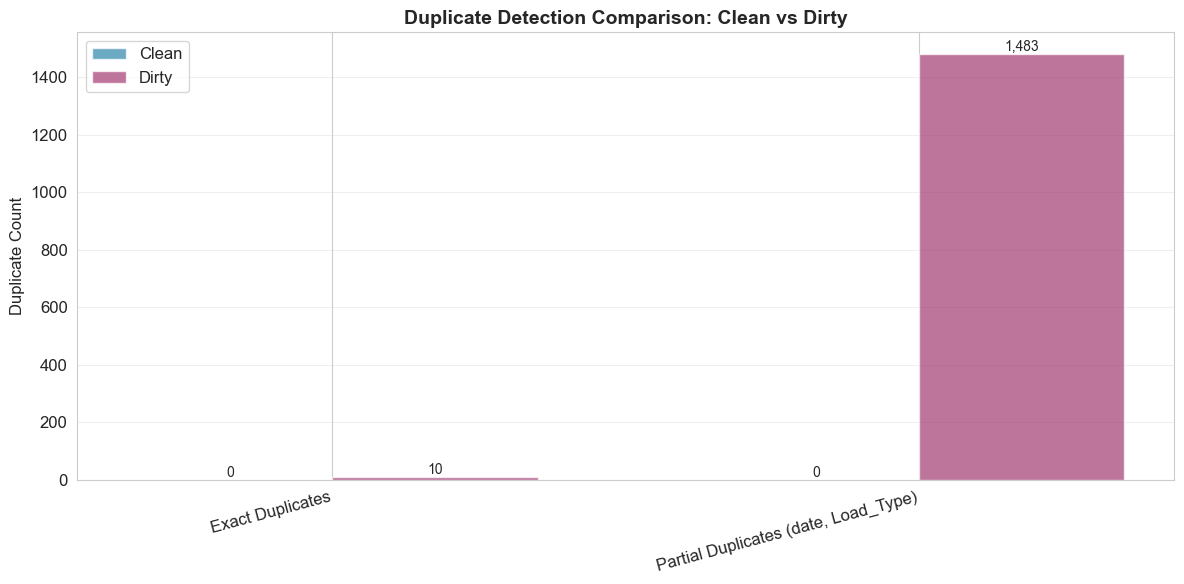

In [35]:
visualize_duplicate_comparison(duplicate_comparison)

### Detección de duplicados: conclusiones principales

**Resumen:**
- Se completó la detección de duplicados utilizando dos métodos: exacto y parcial.
- Se identificaron filas duplicadas tanto en conjuntos de datos limpios como sucios.
- Se compararon los patrones de duplicados para cuantificar los duplicados introducidos.
- Se analizaron los grupos de duplicados para comprender los patrones.

**Métodos de detección:**
1. **Duplicados exactos:** filas que son completamente idénticas en todas las columnas.
   
- Indica posibles errores en la recopilación de datos o problemas de ETL
   - Normalmente deben eliminarse (mantener solo una instancia)
2. **Duplicados parciales:** filas con columnas clave duplicadas (fecha + Load_Type)
- Indica múltiples mediciones para la misma marca de tiempo y tipo de carga
- Puede representar múltiples lecturas legítimas o problemas de calidad de los datos
- Requiere conocimientos del dominio para determinar el tratamiento adecuado

**Observaciones:**
- La detección de duplicados revela problemas de calidad en la recopilación de datos y ETL
- Los duplicados exactos son problemas claros de calidad de los datos
- Los duplicados parciales pueden indicar:
- Ingestión de datos duplicados
- Múltiples sensores que registran el mismo evento
- Problemas de sincronización de datos
- Múltiples mediciones legítimas (menos probable para datos de series temporales)

**Implicaciones para la limpieza de datos:**
- **Duplicados exactos:** eliminar todos excepto uno (utilizar `df.unique()`)
- **Duplicados parciales:** considerar múltiples estrategias:
- Conservar la primera aparición
- Conservar la última aparición
- Agregar (media, mediana) si los valores difieren
- Marcar para revisión manual si es crítico
- Documentar la estrategia de eliminación de duplicados en el proceso de limpieza
- Realizar un seguimiento del número de duplicados eliminados para el registro de auditoría

## 8. Validación de rango

Esta sección valida que los valores numéricos se encuentren dentro de los rangos lógicos esperados. Las violaciones de rango pueden indicar:

- Errores en la introducción de datos
- Fallos en el funcionamiento de los sensores
- Corrupción de datos
- Valores imposibles o físicamente irreales


In [36]:
# Define range rules based on domain knowledge
RANGE_RULES = {
    "Usage_kWh": {"min": clean_df['Usage_kWh'].min(), "max": clean_df['Usage_kWh'].max()},
    "Lagging_Current_Reactive.Power_kVarh": {"min": clean_df['Lagging_Current_Reactive.Power_kVarh'].min(), "max": clean_df['Lagging_Current_Reactive.Power_kVarh'].max()},
    "Leading_Current_Reactive_Power_kVarh": {"min": clean_df['Leading_Current_Reactive_Power_kVarh'].min(), "max": clean_df['Leading_Current_Reactive_Power_kVarh'].max()},
    "CO2(tCO2)": {"min": clean_df['CO2(tCO2)'].min(), "max": clean_df['CO2(tCO2)'].max()},
    "Lagging_Current_Power_Factor": {"min": clean_df['Lagging_Current_Power_Factor'].min(), "max": clean_df['Lagging_Current_Power_Factor'].max()},
    "Leading_Current_Power_Factor": {"min": clean_df['Leading_Current_Power_Factor'].min(), "max": clean_df['Leading_Current_Power_Factor'].max()},
    "NSM": {"min": clean_df['NSM'].min(), "max": clean_df['NSM'].max()},
}

print("Range Rules Defined:")
for col, rules in RANGE_RULES.items():
    print(f"{col}:")
    print(f"  Min: {rules['min']}")
    print(f"  Max: {rules['max']}")
    print()

Range Rules Defined:
Usage_kWh:
  Min: 0.0
  Max: 157.18

Lagging_Current_Reactive.Power_kVarh:
  Min: 0.0
  Max: 96.91

Leading_Current_Reactive_Power_kVarh:
  Min: 0.0
  Max: 27.76

CO2(tCO2):
  Min: 0.0
  Max: 0.07

Lagging_Current_Power_Factor:
  Min: 0.0
  Max: 100.0

Leading_Current_Power_Factor:
  Min: 0.0
  Max: 100.0

NSM:
  Min: 0
  Max: 85500



In [48]:
# Validate ranges in dirty dataset
dirty_range_validation = validate_ranges(dirty_df, RANGE_RULES, "Dirty Dataset")

# Create DataFrame for display
dirty_range_df = pl.DataFrame([
    {
        "column": col,
        "min_expected": info['min_expected'],
        "max_expected": info['max_expected'],
        "total_count": info['total_count'],
        "violations": info['violations'],
        "violation_pct": info['violation_percentage'],
        "status": info['status']
    }
    for col, info in dirty_range_validation.items()
]).sort("violations", descending=True)

print("\nRange Validation Results:")
display(dirty_range_df)



Dirty Dataset - Range Validation:
  Columns validated: 7
  Columns with violations: 7
  Total violations: 1,829

Range Validation Results:


column,min_expected,max_expected,total_count,violations,violation_pct,status
str,f64,f64,i64,i64,f64,str
"""Leading_Current_Power_Factor""",0.0,100.0,33458,343,1.03,"""violations_found"""
"""Lagging_Current_Power_Factor""",0.0,100.0,33456,321,0.96,"""violations_found"""
"""Usage_kWh""",0.0,157.18,33466,304,0.91,"""violations_found"""
"""Lagging_Current_Reactive.Power…",0.0,96.91,33431,276,0.83,"""violations_found"""
"""CO2(tCO2)""",0.0,0.07,33484,226,0.67,"""violations_found"""
"""Leading_Current_Reactive_Power…",0.0,27.76,33449,212,0.63,"""violations_found"""
"""NSM""",0.0,85500.0,33456,147,0.44,"""violations_found"""


In [49]:
# Validate ranges in clean dataset
clean_range_validation = validate_ranges(clean_df, RANGE_RULES, "Clean Dataset")

# Create DataFrame for display
clean_range_df = pl.DataFrame([
    {
        "column": col,
        "min_expected": info['min_expected'],
        "max_expected": info['max_expected'],
        "total_count": info['total_count'],
        "violations": info['violations'],
        "violation_pct": info['violation_percentage'],
        "status": info['status']
    }
    for col, info in clean_range_validation.items()
]).sort("violations", descending=True)

print("\nRange Validation Results:")
display(clean_range_df)



Clean Dataset - Range Validation:
  Columns validated: 7
  Columns with violations: 0
  Total violations: 0

Range Validation Results:


column,min_expected,max_expected,total_count,violations,violation_pct,status
str,f64,f64,i64,i64,f64,str
"""Usage_kWh""",0.0,157.18,35040,0,0.0,"""valid"""
"""Lagging_Current_Reactive.Power…",0.0,96.91,35040,0,0.0,"""valid"""
"""Leading_Current_Reactive_Power…",0.0,27.76,35040,0,0.0,"""valid"""
"""CO2(tCO2)""",0.0,0.07,35040,0,0.0,"""valid"""
"""Lagging_Current_Power_Factor""",0.0,100.0,35040,0,0.0,"""valid"""
"""Leading_Current_Power_Factor""",0.0,100.0,35040,0,0.0,"""valid"""
"""NSM""",0.0,85500.0,35040,0,0.0,"""valid"""


In [50]:
# Show examples for dirty dataset
show_range_violation_examples(dirty_range_validation, "Dirty Dataset")


Dirty Dataset - Range Violation Examples:

  Column: Usage_kWh
    Expected range: [0.0, 157.18]
    Violations: 304 (0.91%)
    Example values: ['1907.29', '767.2', '658.61', '173.53', '203.04']

  Column: Lagging_Current_Reactive.Power_kVarh
    Expected range: [0.0, 96.91]
    Violations: 276 (0.83%)
    Example values: ['886.0', '671.0', '766.0', '696.22', '496.07']

  Column: Leading_Current_Reactive_Power_kVarh
    Expected range: [0.0, 27.76]
    Violations: 212 (0.63%)
    Example values: ['1321.92', '445.0', '600.1600000000001', '808.99', '126.36000000000001']

  Column: CO2(tCO2)
    Expected range: [0.0, 0.07]
    Violations: 226 (0.67%)
    Example values: ['786.03', '999.0', '874.03', '536.0', '229.0']

  Column: Lagging_Current_Power_Factor
    Expected range: [0.0, 100.0]
    Violations: 321 (0.96%)
    Example values: ['3408.84', '840.54', '655.98', '2200.0', '2458.33']

  Column: Leading_Current_Power_Factor
    Expected range: [0.0, 100.0]
    Violations: 343 (1.03%)

In [51]:
# Show examples for clean dataset
show_range_violation_examples(clean_range_validation, "Clean Dataset")


Clean Dataset - Range Violation Examples:
  ✓ No range violations found


In [52]:
# Compare range violations
range_comparison = compare_range_violations(dirty_range_validation, clean_range_validation)

print("FULL RANGE VIOLATION COMPARISON")
display(range_comparison)

FULL RANGE VIOLATION COMPARISON


column,dirty_violations,dirty_pct,clean_violations,clean_pct,difference,issue_introduced
str,i64,f64,i64,f64,i64,bool
"""Leading_Current_Power_Factor""",343,1.03,0,0.0,343,true
"""Lagging_Current_Power_Factor""",321,0.96,0,0.0,321,true
"""Usage_kWh""",304,0.91,0,0.0,304,true
"""Lagging_Current_Reactive.Power…",276,0.83,0,0.0,276,true
"""CO2(tCO2)""",226,0.67,0,0.0,226,true
"""Leading_Current_Reactive_Power…",212,0.63,0,0.0,212,true
"""NSM""",147,0.44,0,0.0,147,true


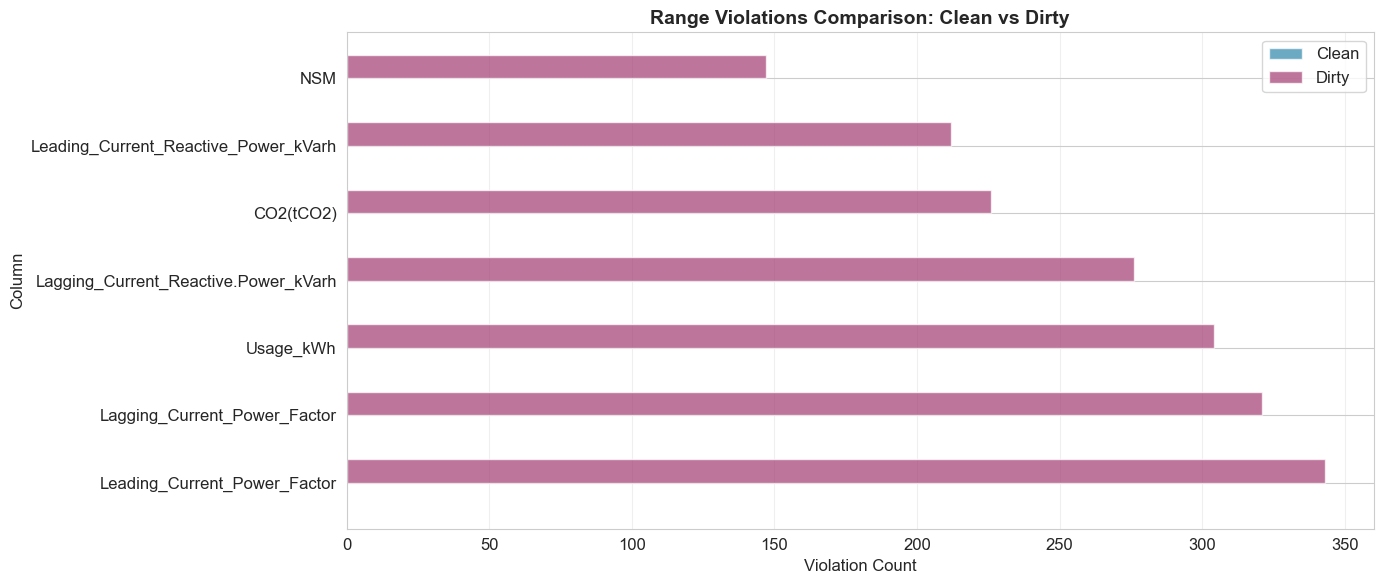

In [53]:
# Create visualization
visualize_range_violations(range_comparison)

### Validación de rangos: conclusiones principales

**Resumen:**
- Se completó la validación de rangos para todas las columnas numéricas según las reglas definidas.
- Se identificaron valores que se encuentran fuera de los rangos correctos esperados.
- Se compararon las diferencias en los rangos entre conjuntos de datos limpios y sucios.

**Tipos de datos fuera de rangos:**
1. **Por debajo del mínimo:** valores inferiores al mínimo definido (a menudo valores negativos cuando solo tienen sentido los valores positivos).
2. **Por encima del máximo:** valores que superan el máximo definido (posibles errores del sensor o corrupción de datos).

**Observaciones:**
- Las infracciones de rango indican problemas de calidad de los datos que deben corregirse.
- Los valores fuera de los límites físicos (por ejemplo, consumo de energía negativo) son imposibles.
- Los valores del factor de potencia fuera de [0, 1] son matemáticamente inválidos
- Los valores extremos pueden indicar un mal funcionamiento del sensor o errores en la introducción de datos

**Causas comunes de las infracciones de rango:**
- Problemas de calibración del sensor
- Errores en la transmisión de datos
- Errores en la introducción manual de datos
- Fallos o errores del sistema
- Errores en la conversión de unidades

**Implicaciones para la limpieza de datos:**
- Los valores fuera de los rangos válidos deben:
  - Marcarse para su revisión.
  - Corregirse si se conoce el valor real.
  - Limitarse a los límites mínimo/máximo (recorte).
  - Establecerse en nulo si no es posible corregirlos.
  - Eliminarse si representan mediciones no válidas.
  - Tener en cuenta la experiencia en el ámbito a la hora de decidir la estrategia de tratamiento.
  - Documentar todas las correcciones basadas en el rango para garantizar la trazabilidad.

## 9. Resumen ejecutivo y recomendaciones

Esta sección ofrece un resumen completo de todos los problemas de calidad de los datos identificados en el análisis y recomendaciones prácticas para el proceso de limpieza de datos.

### Resumen de Problemas Identificados

#### 1. Problemas de Esquema (Severidad: ALTA)
- 7 columnas con tipos de datos incorrectos
- 1 columna adicional con tipos mixtos
- +700 filas adicionales

#### 2. Problemas de Completitud (Severidad: ALTA)
- Valores nulos introducidos en múltiples columnas
- Impacto en análisis y modelado

#### 3. Problemas de Validez (Severidad: ALTA)
- Violaciones de rango detectadas
- Valores categóricos inválidos

#### 4. Problemas de Precisión (Severidad: MEDIA)
- Valores atípicos identificados
- Cambios en distribuciones estadísticas

#### 5. Problemas de Consistencia (Severidad: MEDIA)
- Registros duplicados
- Inconsistencias en formato

### Recomendaciones para US-006 (Pipeline de Limpieza)

#### Fase 1: Validación de Esquema
1. **Conversión de Tipos:**
   - Convertir columnas String a tipos numéricos apropiados
   - Implementar manejo de errores para valores no convertibles
   - Registrar valores problemáticos para revisión

2. **Manejo de Columna Mixta:**
   - Analizar contexto de negocio de `mixed_type_col`
   - Decidir estrategia: eliminar, separar o convertir
   - Documentar decisión

#### Fase 2: Limpieza de Datos

1. **Valores Nulos:**
   - Identificar patrones de valores faltantes
   - Implementar estrategias de imputación apropiadas
   - Considerar eliminación si porcentaje es alto

2. **Valores Atípicos:**
   - Validar si son errores o valores legítimos
   - Aplicar transformaciones o caps según contexto
   - Documentar decisiones de tratamiento

3. **Duplicados:**
   - Eliminar duplicados exactos
   - Analizar duplicados parciales caso por caso
   - Mantener registro de eliminaciones

4. **Validación de Rangos:**
   - Implementar reglas de validación automáticas
   - Corregir o marcar valores fuera de rango
   - Establecer alertas para valores sospechosos

#### Fase 3: Validación y Documentación

1. **Pruebas de Calidad:**
   - Verificar que todos los problemas fueron abordados
   - Comparar estadísticas antes/después
   - Validar integridad de datos

2. **Documentación:**
   - Registrar todas las transformaciones aplicadas
   - Documentar decisiones y justificaciones
   - Crear informe de calidad de datos

3. **Monitoreo:**
   - Establecer métricas de calidad de datos
   - Implementar alertas para problemas futuros
   - Crear dashboard de calidad

### Priorización

**Prioridad Alta (Crítico):**
- Conversión de tipos de datos
- Manejo de valores nulos en columnas clave
- Validación de rangos

**Prioridad Media (Importante):**
- Detección y manejo de duplicados
- Tratamiento de valores atípicos
- Análisis de columna con tipos mixtos

**Prioridad Baja (Deseable):**
- Optimización de distribuciones
- Mejoras de formato
- Documentación extendida

---

## Conclusiones

Este análisis exhaustivo proporciona una base sólida para la implementación del pipeline de limpieza de datos (US-006). Los problemas identificados son manejables con las estrategias apropiadas, y el dataset limpio resultante será adecuado para análisis y modelado de machine learning.

### Próximos Pasos

1. Revisar y aprobar recomendaciones con el equipo
2. Implementar pipeline de limpieza en fases
3. Validar resultados en cada fase
4. Documentar proceso y decisiones
5. Establecer monitoreo continuo de calidad

---